### LSTM (Long-short time memory) model for SOC prediction with using LG 18650HG2 Li-ion Battery and Panasonic 18650PF

In [18]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [42]:
PROCESSED_DATA_DIR = '../../datasets/combined_dataset'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 2048
SEQUENCE_LENGTH = 20  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [20]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [21]:
# Custom dataset class for LSTM
class BatteryDatasetLSTM(Dataset):
    def __init__(self, data_tensor, labels_tensor, sequence_length=50, filenames=None, times=None):
        self.sequence_length = sequence_length
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        sequence = self.features[idx:idx_end]
        label = self.labels[idx_end - 1]
        filename = self.filenames[idx_end - 1]
        time = self.times[idx_end - 1]  

        sequence = sequence.clone().detach()
        label = label.clone().detach()

        return sequence, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [22]:
# SoCLSTM Model
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SoCLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [23]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001, flag=False):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')
        
        if flag:
            model_path = "soc_lstm_model.pth"
            torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)
        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [24]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [25]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W],Time [min],Rounded_Time
0,2017-05-30 12:56:50,50.000996,3.95155,-1.21840,0.539533,-0.01341,0.000029,-0.013320,0.994895,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-4.814569,NaN,NaN
1,2017-05-30 12:56:50,50.100000,3.93868,-1.38009,0.539533,-0.01345,0.000028,-0.013358,0.994881,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.435733,NaN,NaN
2,2017-05-30 12:56:50,50.198993,3.93032,-1.42908,0.550856,-0.01349,0.000027,-0.013397,0.994866,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.616742,NaN,NaN
3,2017-05-30 12:56:50,50.302000,3.92646,-1.44378,0.550856,-0.01353,0.000029,-0.013438,0.994850,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.668944,NaN,NaN
4,2017-05-30 12:56:50,50.407995,3.92324,-1.45032,0.550856,-0.01357,0.000029,-0.013481,0.994833,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.689953,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240964,2018-12-26 19:03:34,4671.577000,3.59885,0.00000,-19.559490,-1.53638,0.000027,-1.537670,0.384547,611_Mixed8_processed.csv,0.000000,77.859617,4672.0
4240965,2018-12-26 19:03:35,4672.579000,3.59885,0.00000,-19.559490,-1.53638,0.000028,-1.537670,0.384547,611_Mixed8_processed.csv,0.000000,77.876317,4673.0
4240966,2018-12-26 19:03:36,4673.577000,3.59902,0.00000,-19.559490,-1.53638,0.000027,-1.537670,0.384547,611_Mixed8_processed.csv,0.000000,77.892950,4674.0
4240967,2018-12-26 19:03:37,4674.580000,3.59902,0.00000,-19.559490,-1.53638,0.000029,-1.537670,0.384547,611_Mixed8_processed.csv,0.000000,77.909667,4675.0


In [26]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W],Time [min],Rounded_Time
0,2017-05-30 12:56:50,50.000996,1.203861,-0.116736,-0.571526,-0.01341,0.000029,1.644273,0.994895,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.221269,NaN,NaN
1,2017-05-30 12:56:50,50.100000,1.158755,-0.201745,-0.571526,-0.01345,0.000028,1.644220,0.994881,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.316949,NaN,NaN
2,2017-05-30 12:56:50,50.198993,1.129455,-0.227501,-0.570765,-0.01349,0.000027,1.644165,0.994866,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.344830,NaN,NaN
3,2017-05-30 12:56:50,50.302000,1.115927,-0.235230,-0.570765,-0.01353,0.000029,1.644107,0.994850,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.352871,NaN,NaN
4,2017-05-30 12:56:50,50.407995,1.104641,-0.238668,-0.570765,-0.01357,0.000029,1.644048,0.994833,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.356107,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240964,2018-12-26 19:03:34,4671.577000,-0.032270,0.523839,-1.922411,-1.53638,0.000027,-0.480707,0.384547,611_Mixed8_processed.csv,0.520335,77.859617,4672.0
4240965,2018-12-26 19:03:35,4672.579000,-0.032270,0.523839,-1.922411,-1.53638,0.000028,-0.480707,0.384547,611_Mixed8_processed.csv,0.520335,77.876317,4673.0
4240966,2018-12-26 19:03:36,4673.577000,-0.031674,0.523839,-1.922411,-1.53638,0.000027,-0.480707,0.384547,611_Mixed8_processed.csv,0.520335,77.892950,4674.0
4240967,2018-12-26 19:03:37,4674.580000,-0.031674,0.523839,-1.922411,-1.53638,0.000029,-0.480707,0.384547,611_Mixed8_processed.csv,0.520335,77.909667,4675.0


In [27]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [28]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [29]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [30]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetLSTM(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetLSTM(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetLSTM(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [43]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'552_Mixed7_processed.csv', '611_Mixed4_processed.csv', '596_HWFET_processed.csv', '611_Mixed3_processed.csv', '571_Mixed5_processed.csv', '604_Mixed8_processed.csv', '610_Mixed2_processed.csv', '06-24-17_19.29 n20degC_Cycle_3_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_HWFET_Pan18650PF_processed.csv', '610_Mixed1_processed.csv', '601_US06_processed.csv', '06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv', '552_Mixed5_processed.csv', '610_LA92_processed.csv', '03-21-17_09.38 25degC_LA92_Pan18650PF_processed.csv', '567_Mixed2_processed.csv', '551_Mixed2_processed.csv', '589_LA92_processed.csv', '03-28-17_12.51 10degC_Cycle_1_Pan18650PF_processed.csv', '06-02-17_10.43 0degC_HWFET_Pan18650PF_processed.csv', '610_HWFET_processed.csv', '571_Mixed4_processed.csv', '590_Mixed5_processed.csv', '589_Mixed2_processed.csv', '03-20-17_19.27 25degC_HWFTb_Pan18650PF_processed.csv', '604_Mixed3_processed.csv', '06-23-17_23.35 n20degC_NN_Pan18650PF_processed.csv', '610_UDDS_pr

In [33]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([3198280, 5])
Test features shape: torch.Size([488241, 5])
Train labels shape: torch.Size([3198280])
Test labels shape: torch.Size([488241])


## Hyperparameter tuning

In [44]:
# Define Optuna objective function
EPOCHS = 10
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    # Instantiate model with suggested hyperparameters
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).type(torch.float32).to(device)

    # Define your loss function and optimizer with suggested hyperparameters
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Call your train and validate function
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Extract last validation loss
    last_val_loss = history['val_loss'][-1]
    return last_val_loss


In [45]:
# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Extract best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial}")

best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

[I 2025-08-05 00:38:31,115] A new study created in memory with name: no-name-69e940a8-ae86-4178-922d-49c11faabbda
Epoch: 0/10: 100%|██████████| 1562/1562 [06:05<00:00,  4.28it/s]


Epoch 1/10, Train Loss: 0.025782203724445053, Validation Loss: 0.0008980025770706494
Time taken for epoch: 365.11637974 seconds


Epoch: 1/10: 100%|██████████| 1562/1562 [05:59<00:00,  4.35it/s]


Epoch 2/10, Train Loss: 0.0016118054013316509, Validation Loss: 0.0008942819607426495
Time taken for epoch: 359.27879357 seconds


Epoch: 2/10:  51%|█████▏    | 803/1562 [03:05<02:55,  4.33it/s]
[W 2025-08-05 00:55:42,455] Trial 0 failed with parameters: {'hidden_size': 41, 'num_layers': 5, 'learning_rate': 4.165428663322513e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\bunae\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\bunae\AppData\Local\Temp\ipykernel_16332\3745601827.py", line 17, in objective
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)
  File "C:\Users\bunae\AppData\Local\Temp\ipykernel_16332\3482212393.py", line 12, in train_and_validate
    for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):
  File "c:\Users\bunae\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\std.py", line 1181, in __iter__
    for obj in iter

KeyboardInterrupt: 

In [24]:
# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

## Best hyperparameters: {'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.00043744795844566733}

In [46]:
# Initialize the model, loss function, and optimizer
# hidden_size = best_hyperparams['hidden_size']
# num_layers = best_hyperparams['num_layers']
# lr = best_hyperparams['learning_rate']

EPOCHS = 20

model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=105, num_layers=3)
model.to(device).type(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=0.0004374)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCLSTM(
  (lstm): LSTM(5, 105, num_layers=3, batch_first=True)
  (fc): Linear(in_features=105, out_features=1, bias=True)
)
Trainable parameters: 225226


Epoch: 0/20: 100%|██████████| 1562/1562 [06:52<00:00,  3.79it/s]


Epoch 1/20, Train Loss: 0.0038851630787821857, Validation Loss: 0.0007086018483405698
Time taken for epoch: 412.05184603 seconds


Epoch: 1/20: 100%|██████████| 1562/1562 [06:57<00:00,  3.74it/s]


Epoch 2/20, Train Loss: 0.0007461279052087296, Validation Loss: 0.0006131095242540393
Time taken for epoch: 417.56276298 seconds


Epoch: 2/20: 100%|██████████| 1562/1562 [06:59<00:00,  3.72it/s]


Epoch 3/20, Train Loss: 0.0006489952028670591, Validation Loss: 0.000529204626374473
Time taken for epoch: 419.47974110 seconds


Epoch: 3/20: 100%|██████████| 1562/1562 [06:54<00:00,  3.77it/s]


Epoch 4/20, Train Loss: 0.0005250029071283655, Validation Loss: 0.00040631361446650095
Time taken for epoch: 414.44595766 seconds


Epoch: 4/20: 100%|██████████| 1562/1562 [06:54<00:00,  3.77it/s]


Epoch 5/20, Train Loss: 0.00044920874529481814, Validation Loss: 0.0004481369503504244
Time taken for epoch: 414.75840425 seconds


Epoch: 5/20: 100%|██████████| 1562/1562 [06:56<00:00,  3.75it/s]


Epoch 6/20, Train Loss: 0.0003915186105018765, Validation Loss: 0.0004935544384897758
Time taken for epoch: 416.13603473 seconds


Epoch: 6/20: 100%|██████████| 1562/1562 [06:58<00:00,  3.73it/s]


Epoch 7/20, Train Loss: 0.0003362030287748876, Validation Loss: 0.000504356842915466
Time taken for epoch: 418.59275985 seconds


Epoch: 7/20: 100%|██████████| 1562/1562 [06:58<00:00,  3.73it/s]


Epoch 8/20, Train Loss: 0.0002945808063394768, Validation Loss: 0.00048138161970927187
Time taken for epoch: 418.91791391 seconds


Epoch: 8/20: 100%|██████████| 1562/1562 [06:59<00:00,  3.73it/s]


Epoch 9/20, Train Loss: 0.0002713606194396254, Validation Loss: 0.0004625402287451096
Time taken for epoch: 419.19162393 seconds
Early stopping triggered


Epoch: 9/20: 100%|██████████| 1562/1562 [06:57<00:00,  3.74it/s]


Epoch 10/20, Train Loss: 0.00024612666303056404, Validation Loss: 0.0005685362735430258
Time taken for epoch: 417.36242604 seconds
Early stopping triggered


Epoch: 10/20: 100%|██████████| 1562/1562 [06:54<00:00,  3.77it/s]


Epoch 11/20, Train Loss: 0.00021947672702296055, Validation Loss: 0.0006122490501810821
Time taken for epoch: 414.28202868 seconds
Early stopping triggered


Epoch: 11/20: 100%|██████████| 1562/1562 [07:06<00:00,  3.66it/s]


Epoch 12/20, Train Loss: 0.0001971775471040098, Validation Loss: 0.0006135147548215797
Time taken for epoch: 426.50447273 seconds
Early stopping triggered


Epoch: 12/20: 100%|██████████| 1562/1562 [07:00<00:00,  3.71it/s]


Epoch 13/20, Train Loss: 0.0001840236988677327, Validation Loss: 0.0006068804753824276
Time taken for epoch: 420.55920029 seconds
Early stopping triggered


Epoch: 13/20: 100%|██████████| 1562/1562 [06:54<00:00,  3.77it/s]


Epoch 14/20, Train Loss: 0.0001714672378910018, Validation Loss: 0.0006006163713120034
Time taken for epoch: 414.25895572 seconds
Early stopping triggered


Epoch: 14/20: 100%|██████████| 1562/1562 [06:56<00:00,  3.75it/s]


Epoch 15/20, Train Loss: 0.00015820145614112212, Validation Loss: 0.0005627348095848452
Time taken for epoch: 416.42072582 seconds
Early stopping triggered


Epoch: 15/20: 100%|██████████| 1562/1562 [06:56<00:00,  3.75it/s]


Epoch 16/20, Train Loss: 0.0001426166243469295, Validation Loss: 0.0005799111212253864
Time taken for epoch: 416.55941677 seconds
Early stopping triggered


Epoch: 16/20: 100%|██████████| 1562/1562 [06:55<00:00,  3.76it/s]


Epoch 17/20, Train Loss: 0.00013224138403177964, Validation Loss: 0.0005920986966090262
Time taken for epoch: 415.84430647 seconds
Early stopping triggered


Epoch: 17/20: 100%|██████████| 1562/1562 [06:54<00:00,  3.77it/s]


Epoch 18/20, Train Loss: 0.00012341163128486385, Validation Loss: 0.0006677456824883187
Time taken for epoch: 414.82709503 seconds
Early stopping triggered


Epoch: 18/20: 100%|██████████| 1562/1562 [06:54<00:00,  3.77it/s]


Epoch 19/20, Train Loss: 0.00011166252368222206, Validation Loss: 0.0006246500448633753
Time taken for epoch: 414.74181938 seconds
Early stopping triggered


Epoch: 19/20: 100%|██████████| 1562/1562 [07:00<00:00,  3.72it/s]


Epoch 20/20, Train Loss: 0.00010751652294861852, Validation Loss: 0.0006823582076249479
Time taken for epoch: 420.33247662 seconds
Early stopping triggered


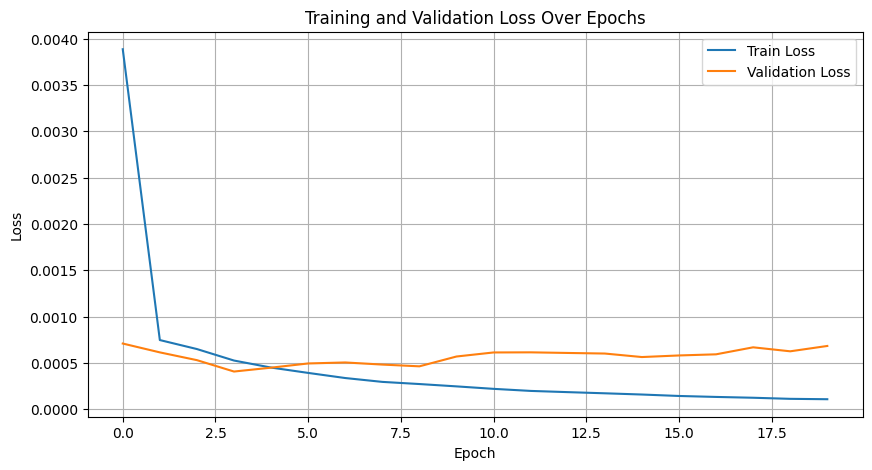

In [47]:
# Train and validate the model
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device, flag=True)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_lstm_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

In [53]:
model_path = "soc_lstm_model.pth"
    
def load_lstm_model(model_path, input_size, hidden_size, num_layers):
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_lstm_model(model_path, input_size=len(FEATURE_COLS), hidden_size=105, num_layers=3)

In [54]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [55]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.001612
Test MAE: 0.028056
Test StdDev: 0.039573


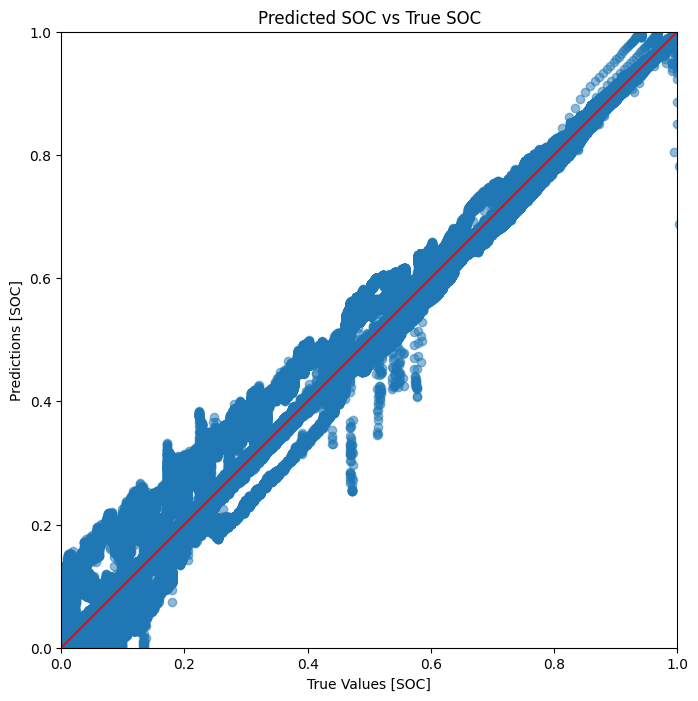

In [56]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

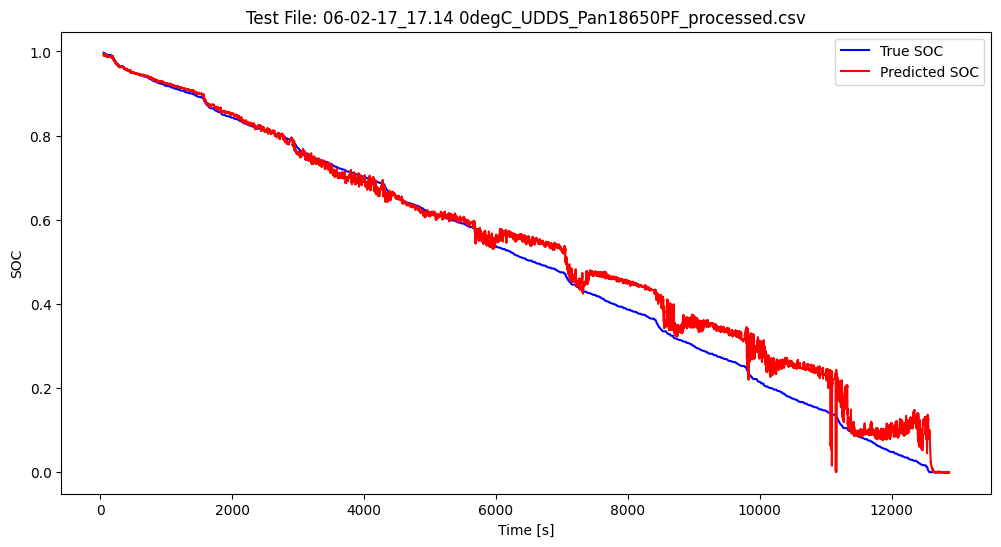

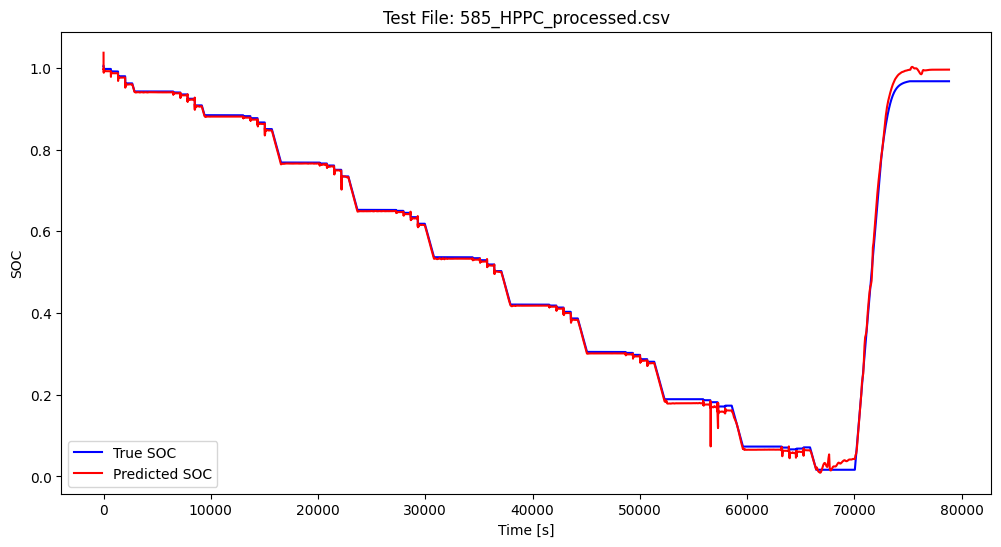

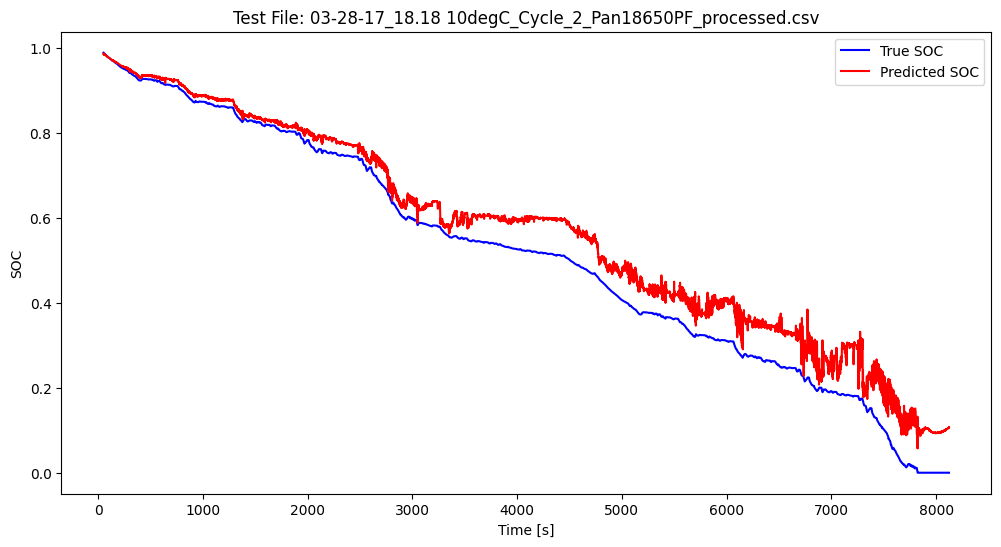

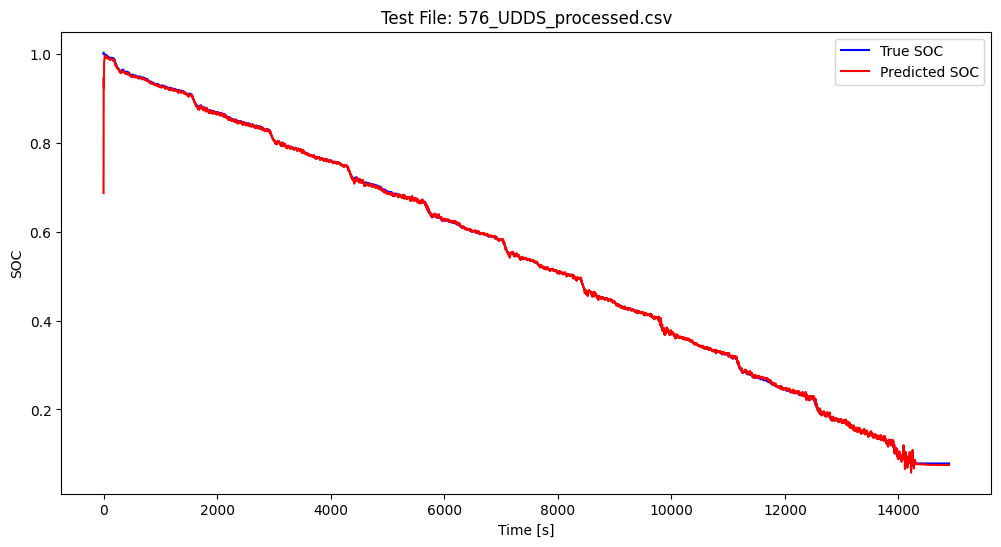

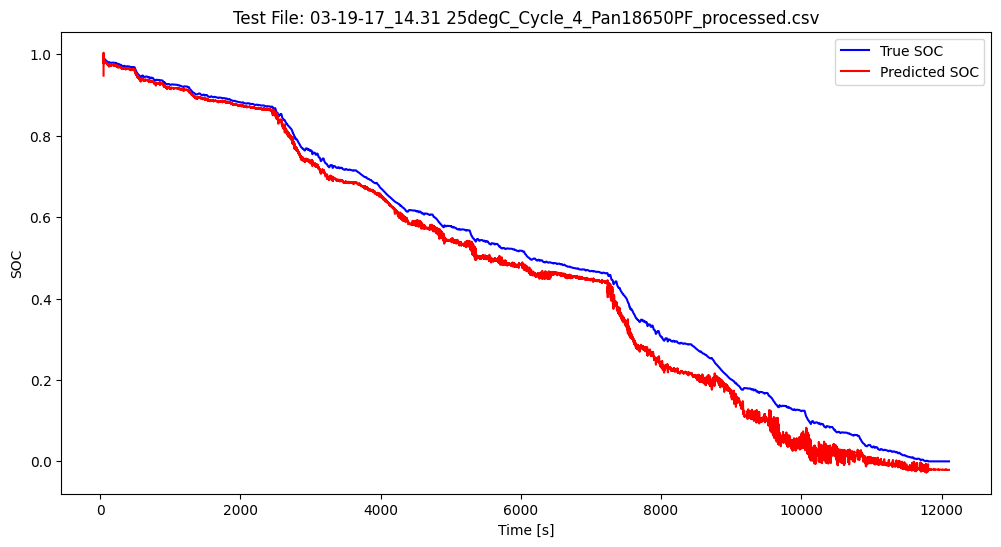

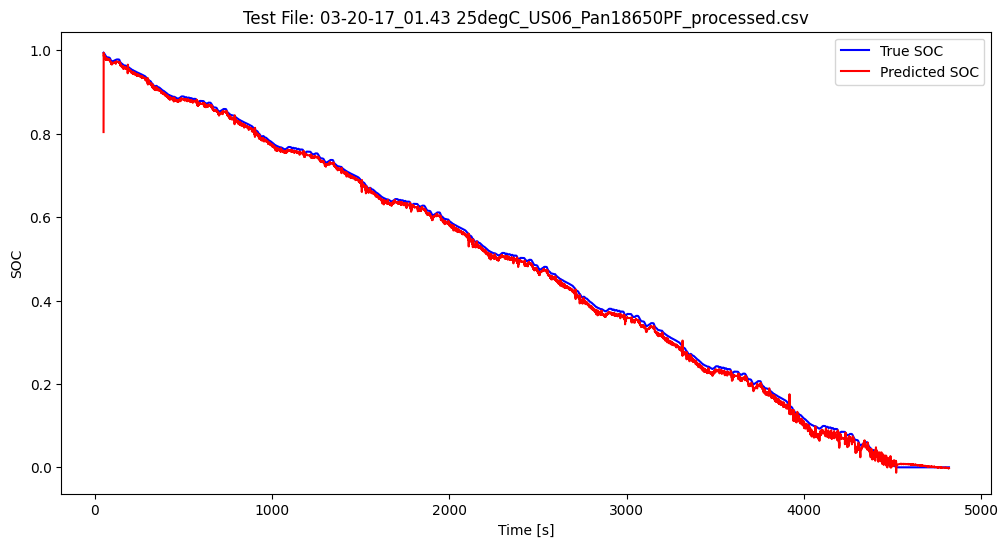

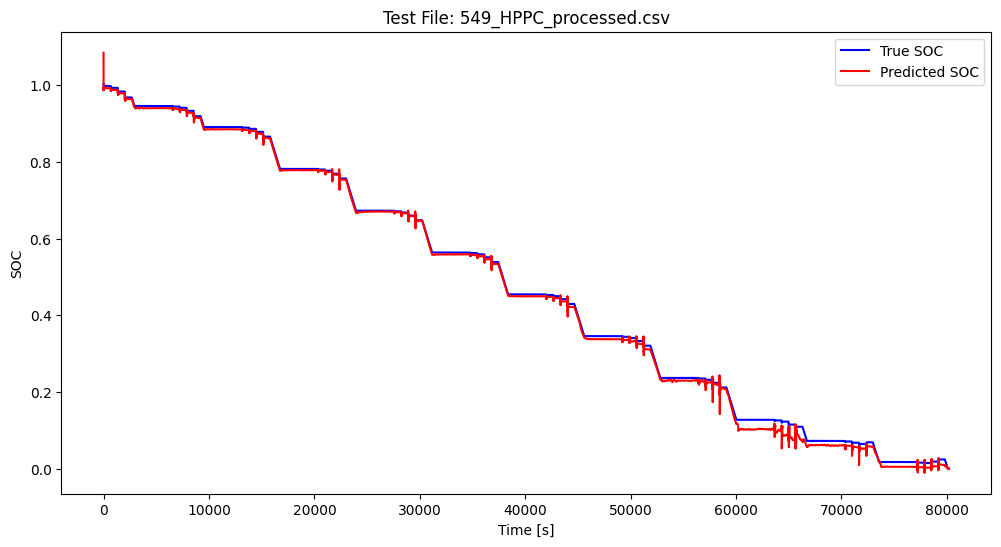

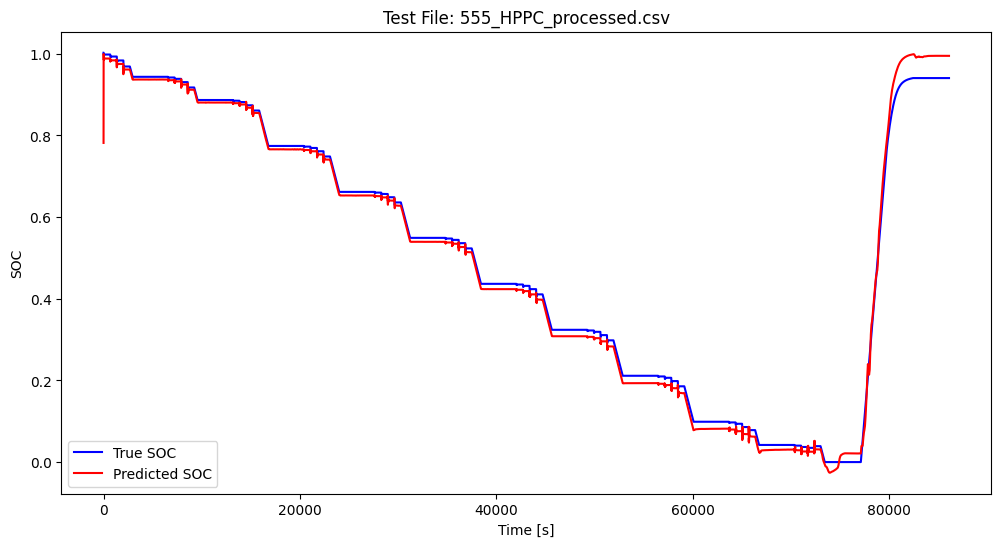

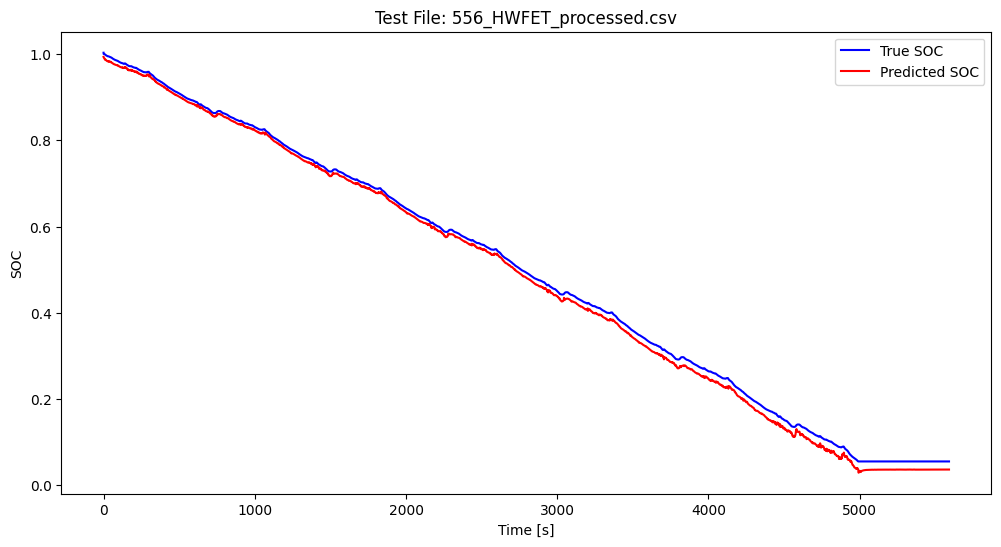

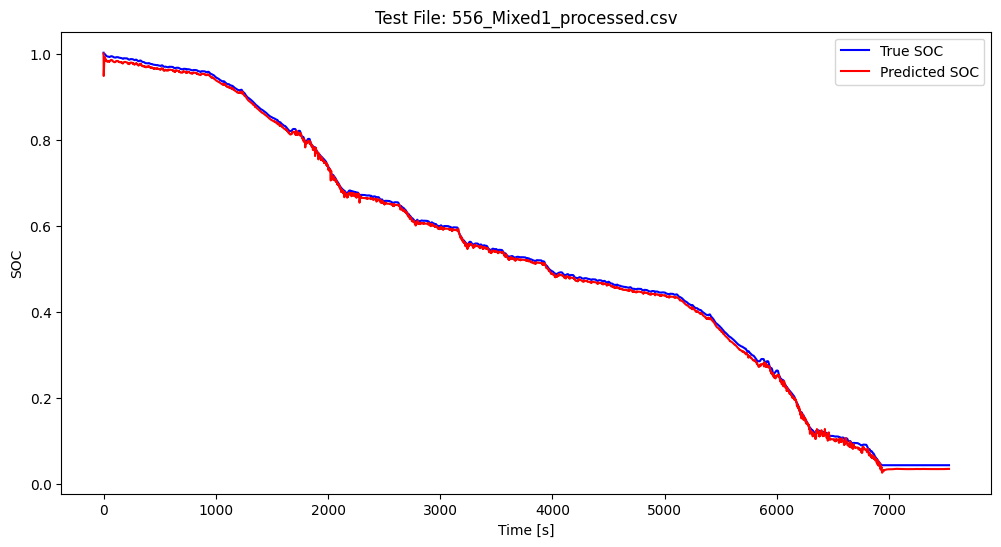

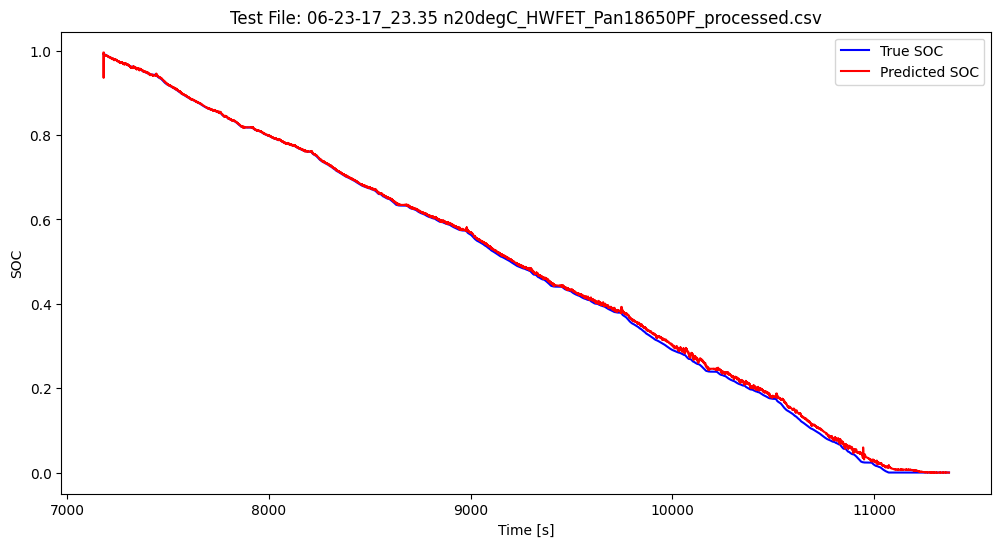

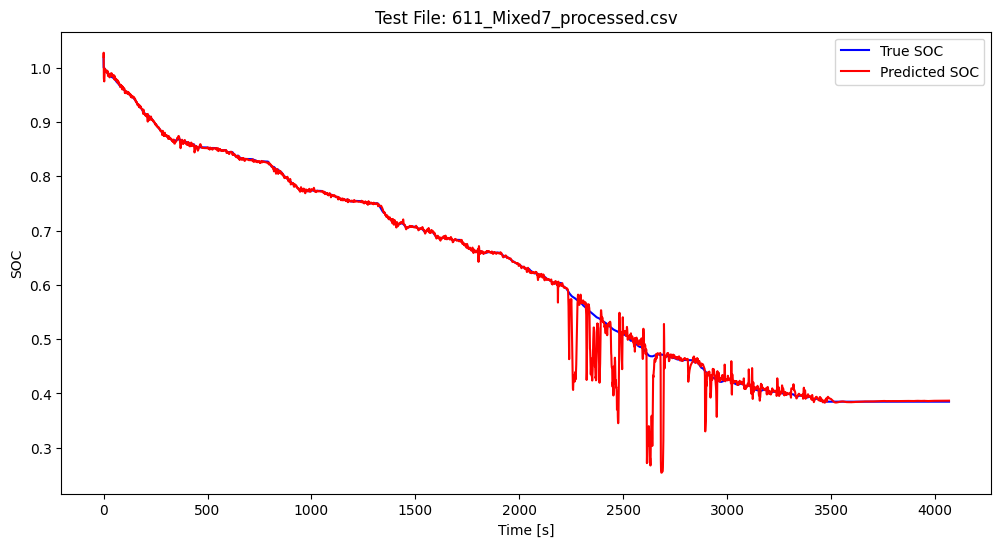

In [57]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)